In [4]:
''' 
Access to improved water sources with children and elderly overlay
'''
import os
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import contextily as ctx
import rasterio
from rasterio.plot import show
import rasterio.mask
import matplotlib.pyplot as plt

os.chdir(r'C:/Users/jtrum/world_bank/data/')

In [5]:
'''
aoi = area of interest
hdsl = high resolution population density of children under 5
ihme = mean percent of population with access to improved water source
'''
aoi = gpd.read_file('aoiLuanda.geojson')
hdsl = rxr.open_rasterio('ago_children_under_five_2020.tif')
ihme = rxr.open_rasterio('IHME_LMIC_WASH_2000_2017_W_IMP_PERCENT_MEAN_2017_Y2020M06D02.TIF')
aoi_bound = aoi.geometry
hdsl_clip = hdsl.rio.clip(aoi_bound)
ihme_clip = ihme.rio.clip(aoi_bound)

In [6]:
print(type(hdsl_clip))
print(type(ihme_clip))
print(type(aoi))


<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [21]:
hdsl_clip2 = hdsl_clip.squeeze()
hdsl_df = hdsl_clip2.to_dataframe(name='percent')
hdsl_df = hdsl_df['percent'].dropna()
ihme_clip2 = ihme_clip.squeeze()
ihme_df = ihme_clip2.to_dataframe(name='percent')
ihme_df = ihme_df[ihme_df.percent != -999999.0]

In [22]:
hdsl_df = hdsl_df.reset_index()
hdsl_df = hdsl_df.rename(columns={'x':'lon', 'y':'lat'})
hdsl_gdf = gpd.GeoDataFrame(hdsl_df, geometry=gpd.points_from_xy(hdsl_df.lon, hdsl_df.lat))

In [23]:
ihme_df =ihme_df.reset_index()


In [24]:
ihme_df

,y,x,band,spatial_ref,percent
0,-8.687501,13.437516,1,0,99.396202
1,-8.687501,13.479183,1,0,99.813766
2,-8.687501,13.520849,1,0,96.345879
3,-8.729168,13.437516,1,0,99.989731
4,-8.729168,13.479183,1,0,99.981781
...,...,...,...,...,...
111,-9.229168,13.187516,1,0,33.793404
112,-9.270834,13.145849,1,0,36.304882
113,-9.270834,13.187516,1,0,36.074020
114,-9.312501,13.145849,1,0,37.536205


In [25]:
ihme_df = ihme_df.rename(columns={'x':'lon', 'y':'lat'})

In [26]:
ihme_gdf = gpd.GeoDataFrame(ihme_df, geometry=(ihme_df.lon, ihme_df.lat))

InvalidIndexError: (0      13.437516
1      13.479183
2      13.520849
3      13.437516
4      13.479183
         ...    
111    13.187516
112    13.145849
113    13.187516
114    13.145849
115    13.187516
Name: lon, Length: 116, dtype: float64, 0     -8.687501
1     -8.687501
2     -8.687501
3     -8.729168
4     -8.729168
         ...   
111   -9.229168
112   -9.270834
113   -9.270834
114   -9.312501
115   -9.312501
Name: lat, Length: 116, dtype: float64)

In [12]:
ihme_gdf

,lat,lon,band,spatial_ref,percent,geometry
0,-8.687501,13.437516,1,0,99.396202,POINT (13.43752 -8.68750)
1,-8.687501,13.479183,1,0,99.813766,POINT (13.47918 -8.68750)
2,-8.687501,13.520849,1,0,96.345879,POINT (13.52085 -8.68750)
3,-8.729168,13.437516,1,0,99.989731,POINT (13.43752 -8.72917)
4,-8.729168,13.479183,1,0,99.981781,POINT (13.47918 -8.72917)
...,...,...,...,...,...,...
111,-9.229168,13.187516,1,0,33.793404,POINT (13.18752 -9.22917)
112,-9.270834,13.145849,1,0,36.304882,POINT (13.14585 -9.27083)
113,-9.270834,13.187516,1,0,36.074020,POINT (13.18752 -9.27083)
114,-9.312501,13.145849,1,0,37.536205,POINT (13.14585 -9.31250)


In [13]:
# Reproject the AOI to match the CRS of the raster datasets
aoi = aoi.to_crs(hdsl.crs)

# Get the geometry of the AOI
aoi_geometry = aoi.geometry.values[0]


In [14]:
# Clip the raster datasets to the AOI
hdsl_clip, hdsl_transform = rasterio.mask.mask(hdsl, shapes=[aoi_geometry], crop=True)
ihme_clip, ihme_transform = rasterio.mask.mask(ihme, shapes=[aoi_geometry], crop=True)

In [16]:
hdsl_clip_dataset = rasterio.open(
    'hdsl_clip.tif',
    'w',
    driver='GTiff',
    height=hdsl_clip.shape[1],
    width=hdsl_clip.shape[2],
    count=1,
    dtype=str(hdsl_clip.dtype),
    crs=hdsl.crs,
    transform=hdsl_transform,
)
hdsl_clip_dataset.write(hdsl_clip[0], 1)
hdsl_clip_dataset.close()

In [17]:
# Create a new GeoDataFrame for the clipped AOI
aoi_clipped = gpd.GeoDataFrame({'geometry': [aoi_geometry]}, crs=hdsl.crs)

In [18]:
# Manually set CRS for GeoDataFrame
aoi_clipped = aoi_clipped.to_crs(epsg=3857)

CRSError: The WKT could not be parsed. OGR Error code 6

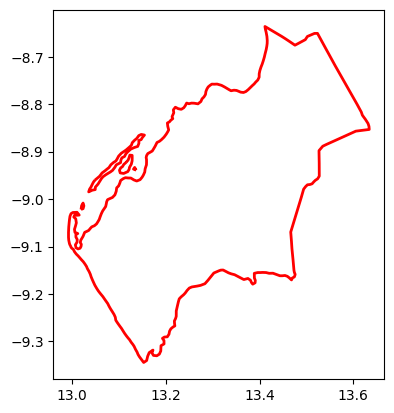

In [21]:
ax = aoi.plot(facecolor="none",
                   edgecolor="red",
                   linewidth=2
                  )
ctx.add_basemap(ax,
               crs=aoi.crs.to_string(),
               source=ctx.providers.CartoDB.Voyager
              )